In [1]:
'''
This file plots CMIP5 RCP - HIST over South Australia
/Users/earl/Desktop/Yang
and places the outputs in
/Users/earl/Dropbox/CMIP5/figures

Earl Duran 
created: 19-Mar-18
e.duran@unsw.edu.au
'''

import os
import xarray as xr
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import sys
import itertools
def find_nearest_index(array, value):
    return int((np.abs(array - value)).argmin())



In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
os.system('sshfs \
erd561@raijin.nci.org.au:/g/data/e14/erd561/CMIP5/bromeliad/ \
/Users/earl/Desktop/Demeter')

256

In [4]:
thefile = open('p04_models_list.txt', 'r')
lines = thefile.read().splitlines()
print(lines)

['ACCESS1-0', 'ACCESS1-3', 'CESM1-BGC', 'CESM1-CAM5', 'CMCC-CMS', 'CMCC-CM', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'FGOALS-s2', 'FIO-ESM', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'HadGEM2-AO', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'MIROC-ESM-CHEM', 'MIROC-ESM', 'MPI-ESM-MR', 'MRI-CGCM3', 'MRI-ESM1', 'NorESM1-ME', 'NorESM1-M']


In [5]:
script_name = nb_name[:-6]
print(script_name)
figures_path = '/Users/earl/Dropbox/CMIP5/figures/'


hist_data_path = '/Users/earl/Desktop/Demeter/historical/'
hist_tos_path = hist_data_path + 'mon/ocean/r1i1p1/tos/latest/'
hist_tauuo_path = hist_data_path + 'mon/ocean/r1i1p1/tauuo/latest/'
hist_tos_list = sorted(os.listdir(hist_tos_path))
hist_tauuo_list = sorted(os.listdir(hist_tauuo_path))
#print(hist_models_list)


rcp85_data_path = '/Users/earl/Desktop/Demeter/rcp85/'
rcp85_tos_path = rcp85_data_path + 'mon/ocean/r1i1p1/tos/latest/'
rcp85_tauuo_path = rcp85_data_path + 'mon/ocean/r1i1p1/tauuo/latest/'
rcp85_tos_list = sorted(os.listdir(rcp85_tos_path))
rcp85_tauuo_list = sorted(os.listdir(rcp85_tauuo_path))
#print(rcp85_models_list)


p06_plot_scatter_areas


In [6]:
tos_hist = {}
tos_rcp85 = {}
tos_anom = {}
lat = {}
lon = {}

tauuo_hist = {}
tauuo_rcp85 = {}
tauuo_anom = {}

plot_tos_list = []

for model in lines:
    # These models are hard to deal with:
    # MIROC5 and inmcm4 have a crazy rotated grid
    # MPI-ESM-LR has a weird grid too
    if model in ['MIROC5', 'MPI-ESM-LR', 'inmcm4']:
        continue
    
    plot_tos_list.append(model)
    
    tos_hist_data = xr.open_dataset(hist_tos_path + model + '_1981-2000mean.nc')
    tos_rcp85_data = xr.open_dataset(rcp85_tos_path + model + '_2081-2100mean.nc')
    tos_hist[model] = tos_hist_data['tos'][0,:,:]
    tos_rcp85[model] = tos_rcp85_data['tos'][0,:,:]
    
    # MPI-ESM-LR has its lon cut-off over Australia
    if model in ['MPI-ESM-LR']:
        tos_hist_now = tos_hist[model]
        tos_hist[model] = tos_hist_now.roll(i=100)
        tos_rcp85_now = tos_rcp85[model]
        tos_rcp85[model] = tos_rcp85_now.roll(i=100)
        
    tos_anom[model] = tos_rcp85[model]-tos_hist[model]
    
    tauuo_hist_data = xr.open_dataset(hist_tauuo_path + model + '_1981-2000mean.nc')
    tauuo_rcp85_data = xr.open_dataset(rcp85_tauuo_path + model + '_2081-2100mean.nc')
    tauuo_hist[model] = tauuo_hist_data['tauuo'][0,:,:]
    tauuo_rcp85[model] = tauuo_rcp85_data['tauuo'][0,:,:]

    # MPI-ESM-LR has its lon cut-off over Australia
    if model in ['MPI-ESM-LR']:
        tauuo_hist_now = tauuo_hist[model]
        tauuo_hist[model] = tauuo_hist_now.roll(i=100)
        tauuo_rcp85_now = tauuo_rcp85[model]
        tauuo_rcp85[model] = tauuo_rcp85_now.roll(i=100)
    
    tauuo_anom[model] = tauuo_rcp85[model]-tauuo_hist[model]
    
    if len(tos_hist_data['lat'].shape) is 2:
        # MPI-ESM-LR and MPI-ESM-MR longitude index should be taken from the end
        if model in ['MPI-ESM-LR', 'MPI-ESM-MR']:
            lat[model] = tos_hist_data['lat'][:,0]
            lon[model] = tos_hist_data['lon'][-1,:]
            print(model + ' OK!')
            
        else:
            lat[model] = tos_hist_data['lat'][:,0]
            lon[model] = tos_hist_data['lon'][0,:]
            print(model + ' OK!')
        
    else:
        lat[model] = tos_hist_data['lat'][:]
        lon[model] = tos_hist_data['lon'][:]
        print(model + ' OK!')
    
    # The GFDL models run need this lon offset fix ...
    if model in ['GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M']:
        lon[model][0:100] += 360
    
    # MPI-ESM-LR lon needs to be offset...
    if model in ['MPI-ESM-LR']:
        lon[model] -= 180
    
    # Also, MPI-ESM-LR and MPI-ESM-MR are flipped upside down...
    # Couldn't find a flip function in xarray...
    if model in ['MPI-ESM-LR', 'MPI-ESM-MR']:
        tos_anom_now = tos_anom[model]
        tos_anom[model] = np.flipud(tos_anom_now)
        tauuo_anom_now = tauuo_anom[model]
        tauuo_anom[model] = np.flipud(tauuo_anom_now)
        
        lat_now = lat[model]
        lat[model] = np.flipud(lat_now)
        
    # HadGEM2-AO, MRI-CGCM3 and MRI-ESM1 need to have their wind stress land masked...
    if model in ['HadGEM2-AO', 'MRI-CGCM3', 'MRI-ESM1']:
        # anything that satisfies the condition is SAFE
        tauuo_anom[model] = tauuo_anom[model].where((tauuo_anom[model] != 0), np.nan)
        
print(len(plot_tos_list))

ACCESS1-0 OK!
ACCESS1-3 OK!
CESM1-BGC OK!
CESM1-CAM5 OK!
CMCC-CMS OK!
CMCC-CM OK!
CNRM-CM5 OK!
CSIRO-Mk3-6-0 OK!
CanESM2 OK!
FGOALS-s2 OK!
FIO-ESM OK!
GFDL-CM3 OK!
GFDL-ESM2G OK!
GFDL-ESM2M OK!
HadGEM2-AO OK!
IPSL-CM5A-LR OK!
IPSL-CM5A-MR OK!
IPSL-CM5B-LR OK!
MIROC-ESM-CHEM OK!
MIROC-ESM OK!
MPI-ESM-MR OK!
MRI-CGCM3 OK!
MRI-ESM1 OK!
NorESM1-ME OK!
NorESM1-M OK!
25


[[ 1.25689697  1.27493286  1.2774353  ...,  0.83554077  0.88452148
   0.92669678]
 [ 1.2310791   1.22497559  1.22531128 ...,  0.84286499  0.88272095
   0.91604614]
 [ 1.24417114  1.24078369  1.23654175 ...,  0.81723022  0.87005615
   0.9197998 ]
 ..., 
 [ 2.55111694  2.53363037  2.55886841 ...,  2.59393311  2.5826416
   2.57022095]
 [ 2.5953064   2.57696533  2.58901978 ...,  2.58331299  2.57244873
   2.55776978]
 [ 2.63464355  2.61087036  2.60934448 ...,  2.56292725  2.55462646
   2.54299927]]
124
99
86
71
127
145


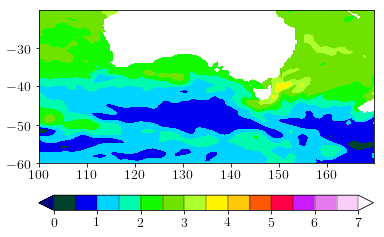

In [18]:
print(tos_anom['MPI-ESM-MR'][lat_S1_idx:lat_N1_idx,lon_W1_idx:lon_E1_idx])

cmap = plt.get_cmap('gist_ncar')
step = 0.5
contf_lvls = np.arange(0,7+1e-08,step)     

lat_N1_idx = find_nearest_index(lat['MPI-ESM-MR'], lat_N1)
lat_S1_idx = find_nearest_index(lat['MPI-ESM-MR'], lat_S1)
lon_W1_idx = find_nearest_index(lon['MPI-ESM-MR'], lon_W1)
lon_E1_idx = find_nearest_index(lon['MPI-ESM-MR'], lon_E1)
    
plt.contourf(lon['MPI-ESM-MR'][lon_W1_idx:lon_E1_idx], 
                 lat['MPI-ESM-MR'][lat_S1_idx:lat_N1_idx], 
                 tos_anom['MPI-ESM-MR'][lat_S1_idx:lat_N1_idx,lon_W1_idx:lon_E1_idx],
                 contf_lvls, cmap=cmap, extend='both')

cbar = plt.colorbar(contf, orientation='horizontal', drawedges=True)

lat_N_idx = find_nearest_index(lat['MPI-ESM-MR'], lat_N)
lat_S_idx = find_nearest_index(lat['MPI-ESM-MR'], lat_S)
lat_S2_idx = find_nearest_index(lat['MPI-ESM-MR'], lat_S2)
lon_W_idx = find_nearest_index(lon['MPI-ESM-MR'], lon_W)
lon_W2_idx = find_nearest_index(lon['MPI-ESM-MR'], lon_W2)
lon_E_idx = find_nearest_index(lon['MPI-ESM-MR'], lon_E)

print(lat_N_idx) 
print(lat_S_idx) 
print(lat_S2_idx) 
print(lon_W_idx) 
print(lon_W2_idx) 
print(lon_E_idx) 


['ACCESS1-0', 'ACCESS1-3', 'CESM1-BGC', 'CESM1-CAM5', 'CMCC-CMS', 'CMCC-CM', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'FGOALS-s2', 'FIO-ESM', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'HadGEM2-AO', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'MIROC-ESM-CHEM', 'MIROC-ESM', 'MPI-ESM-MR', 'MRI-CGCM3', 'MRI-ESM1', 'NorESM1-ME', 'NorESM1-M']


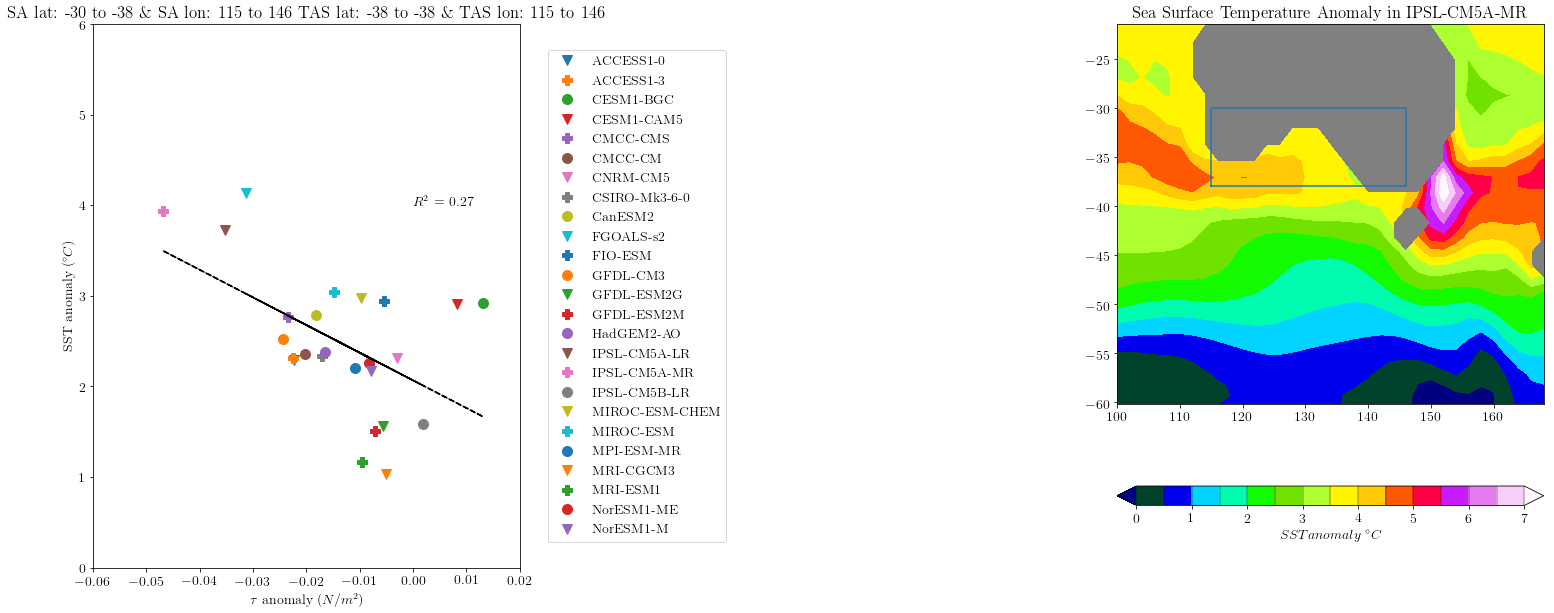

In [29]:
matplotlib.rcParams.update({'font.size': 14}) 
row = 1
col = 3
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.close('all')
fig = plt.figure() 
fig.set_size_inches(26, 10)

tos_anom_mean = {}
tauuo_anom_mean = {}

lat_N = -30
lat_S = -38
lat_S2 = lat_S
lon_W = 115
lon_W2 = lon_W
lon_E = 146
area_name = 'lat' + str(lat_N) + str(lat_S) + 'lon' + str(lon_W) + str(lon_E)

tos_anom_mean_now = []
tauuo_anom_mean_now = []

marker = itertools.cycle(('v', 'P', 'o')) 

ax = fig.add_subplot(row, col, 1)

for idx, t in enumerate(lines):    
    lat_N_idx = find_nearest_index(lat[t], lat_N)
    lat_S_idx = find_nearest_index(lat[t], lat_S)
    lat_S2_idx = find_nearest_index(lat[t], lat_S2)
    lon_W_idx = find_nearest_index(lon[t], lon_W)
    lon_W2_idx = find_nearest_index(lon[t], lon_W2)
    lon_E_idx = find_nearest_index(lon[t], lon_E)
    
#     tos_anom_mean_now_model = (np.nanmean(tos_anom[t][lat_S_idx:lat_N_idx,lon_W_idx:lon_E_idx]) + 
#                                np.nanmean(tos_anom[t][lat_S2_idx:lat_S_idx,lon_W2_idx:lon_E_idx]))/2
    
#     tauuo_anom_mean_now_model = (np.nanmean(tauuo_anom[t][lat_S_idx:lat_N_idx,lon_W_idx:lon_E_idx]) + 
#                                 np.nanmean(tauuo_anom[t][lat_S2_idx:lat_S_idx,lon_W2_idx:lon_E_idx]))/2
    
    tos_anom_mean_now_model = np.nanmean(tos_anom[t][lat_S_idx:lat_N_idx,lon_W_idx:lon_E_idx])
    
    tauuo_anom_mean_now_model = np.nanmean(tauuo_anom[t][lat_S_idx:lat_N_idx,lon_W_idx:lon_E_idx])
    
    plt.plot(tauuo_anom_mean_now_model,tos_anom_mean_now_model, 
             marker = next(marker), markersize=10 ,linestyle='')

    tos_anom_mean_now.append(tos_anom_mean_now_model)
    tauuo_anom_mean_now.append(tauuo_anom_mean_now_model)

print(lines)

plt.legend(lines, loc='center right', bbox_to_anchor=(1.5, 0.5))

fit = np.polyfit(tauuo_anom_mean_now,tos_anom_mean_now,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.plot(tauuo_anom_mean_now, fit_fn(tauuo_anom_mean_now), '--k')

R2 = np.corrcoef(tauuo_anom_mean_now, tos_anom_mean_now)[0, 1]**2

ax.text(0, 4, '$R^2$ = ' + str(np.round(R2*100)/100))

plt.xlabel(r'$\tau$ anomaly ($N/m^2$)')
plt.ylabel('SST anomaly ($^{\circ}C$)')

plt.xlim([-0.06, 0.02])
plt.ylim([0, 6])

plt.title('SA lat: ' + str(lat_N) + ' to ' + str(lat_S) + ' \& SA lon: ' + str(lon_W) + ' to ' + str(lon_E) + 
         ' TAS lat: ' + str(lat_S) + ' to ' + str(lat_S2) + ' \& TAS lon: ' + str(lon_W2) + ' to ' + str(lon_E))

ax = fig.add_subplot(row, col, 3)


cmap = plt.get_cmap('gist_ncar')
step = 0.5
contf_lvls = np.arange(0,7+1e-08,step)               

ax.set_facecolor('grey')

lat_N1 = -20
lat_S1 = -60
lon_W1 = 100
lon_E1 = 170
lat_N1_idx = find_nearest_index(lat['IPSL-CM5A-MR'], lat_N1)
lat_S1_idx = find_nearest_index(lat['IPSL-CM5A-MR'], lat_S1)
lon_W1_idx = find_nearest_index(lon['IPSL-CM5A-MR'], lon_W1)
lon_E1_idx = find_nearest_index(lon['IPSL-CM5A-MR'], lon_E1)

contf = plt.contourf(lon['IPSL-CM5A-MR'][lon_W1_idx:lon_E1_idx], 
                     lat['IPSL-CM5A-MR'][lat_S1_idx:lat_N1_idx], 
                     tos_anom['IPSL-CM5A-MR'][lat_S1_idx:lat_N1_idx,lon_W1_idx:lon_E1_idx],
                     contf_lvls, cmap=cmap, extend='both')

plot = plt.plot([lon_W,lon_W2,lon_W2,lon_E,lon_E,lon_W,lon_W], [lat_S,lat_S,lat_S2,lat_S2,lat_N,lat_N,lat_S])

ax.set_title('Sea Surface Temperature Anomaly in ' + 'IPSL-CM5A-MR')

cbar = plt.colorbar(contf, orientation='horizontal', drawedges=True)
cbar.set_label(r'$SST anomaly$ $^{\circ}C$') 
cbar.set_ticks(contf_lvls[np.arange(0,np.size(contf_lvls),2)])


output_ls = os.listdir(figures_path)
if not script_name:
    script_name = 'test'
elif script_name not in output_ls:
    os.mkdir(figures_path + '/' + script_name)

plt.savefig(figures_path + '/' + script_name + '/' + script_name[0:3] \
            + '_fig1_' + 'lat' + str(round(lat_S2)) + str(round(lat_N)) + str(round(lat_S)) + 
            'lon' + str(round(lon_W2)) + str(round(lon_W)) + str(round(lon_E)) + 
            '.png', bbox_inches='tight', dpi=200)

In [24]:
print(tos_anom_mean_now[20])
print(tos_anom_mean_now)

nan
[<xarray.DataArray 'tos' ()>
array(2.6774098873138428), <xarray.DataArray 'tos' ()>
array(2.265286922454834), <xarray.DataArray 'tos' ()>
array(3.1849422454833984), <xarray.DataArray 'tos' ()>
array(3.245572090148926), <xarray.DataArray 'tos' ()>
array(2.547630786895752), <xarray.DataArray 'tos' ()>
array(2.3178017139434814), <xarray.DataArray 'tos' ()>
array(2.179049015045166), <xarray.DataArray 'tos' ()>
array(2.12563419342041), <xarray.DataArray 'tos' ()>
array(3.110276699066162), <xarray.DataArray 'tos' ()>
array(4.619231224060059), <xarray.DataArray 'tos' ()>
array(2.877143383026123), <xarray.DataArray 'tos' ()>
array(2.4688844680786133), <xarray.DataArray 'tos' ()>
array(1.5453331470489502), <xarray.DataArray 'tos' ()>
array(1.7268998622894287), <xarray.DataArray 'tos' ()>
array(2.7147607803344727), <xarray.DataArray 'tos' ()>
array(3.193519115447998), <xarray.DataArray 'tos' ()>
array(3.3830878734588623), <xarray.DataArray 'tos' ()>
array(1.4952645301818848), <xarray.DataArr